In [56]:
import numpy as np
import sklearn
from numpy import tanh
import sys
sys.path.append('..')
import pandas as pd
from utils import load_narma
import matplotlib.pyplot as plt

In [9]:
x_train,y_train, x_val, y_val, x_test, y_test = load_narma('../datasets/NARMA10.csv', format='np')
x_train.shape

(4000, 1)

In [10]:
class LeastMeanSquares():
    def __init__(self) -> None:
        pass
    def fit(self, H, y):
        H_pinv =  np.linalg.pinv(H)
        self.W = H_pinv @ y
        
    def predict(self, H):
        return  H @ self.W

In [43]:
import sklearn.linear_model


class EchoStateNetwork():
    def __init__(self, input_size, hidden_size, rho_h, omega_x, head = sklearn.linear_model.LinearRegression()) -> None:
        self.W_x = np.random.uniform( low=-1, high=1, size=[hidden_size, input_size]) # input to hidden transition TODO: implement more initialization strategies
        self.W_h = np.random.uniform(low=-1, high=1, size=[hidden_size, hidden_size]) # hidden to hidden transition
        self.last_h = np.zeros([hidden_size, 1])
        self.bias = np.ones_like(self.last_h) # TODO: implement more initialization strategies
        
        # initialize at stability
        norm_W_x = np.linalg.norm(self.W_x)
        self.W_x *= omega_x / norm_W_x

        rho = max(abs(np.linalg.eigvals(self.W_h)))
        self.W_h *= rho_h/rho
        self.head=head
    
    def create_reservoir(self, X):
        for x_i in X:
            x_i = x_i.reshape(-1,1)
            self.last_h= tanh(self.W_x @ x_i  + self.W_h @ self.last_h + self.bias)
            self.hidden_states.append(self.last_h)
        self.hidden_states=np.stack( self.hidden_states, axis=0).squeeze()

    def fit(self, X, y, washout =10):
        """
            params:
            X: list of numpy arrays or numpy array of shape sequence_length x input_size
            y: labels of shape sequence_length x n_features
        """
        self.hidden_states=[]
        # create the reservoir
        self.create_reservoir(X)
        #discard the washout
        self.hidden_states=self.hidden_states[washout:,:] 
        # print(self.hidden_states.shape)
        y = y[washout:, :]

        self.head.fit(self.hidden_states, y)

    def predict(self, X):
        self.hidden_states=[]
        # create the reservoir
        self.create_reservoir(X)
        y_pred = self.head.predict(self.hidden_states)
        return y_pred


        
    

In [48]:
input_size=1
hidden_size=300
rho_h=1.1
omega_x =1.1
washout=1000
head =LeastMeanSquares()
esn1 = EchoStateNetwork(input_size, hidden_size, rho_h, omega_x, head=head)
esn2 = EchoStateNetwork(input_size, hidden_size, rho_h, omega_x)
esn1.fit(x_train, y_train, washout=washout)
esn2.fit(x_train, y_train, washout=washout)

In [49]:
y_val_pred1 =esn1.predict(x_val)
y_val_pred2 =esn2.predict(x_val)

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae1 = mean_absolute_error(y_val, y_val_pred1)
mse1 = mean_squared_error(y_val, y_val_pred1)
mae2 = mean_absolute_error(y_val, y_val_pred2)
mse2 = mean_squared_error(y_val, y_val_pred2)


mae1, mse1, mae2, mse2

(0.0013988182838947979,
 3.2325268088718076e-06,
 0.0009945027350622695,
 1.799900034138342e-06)

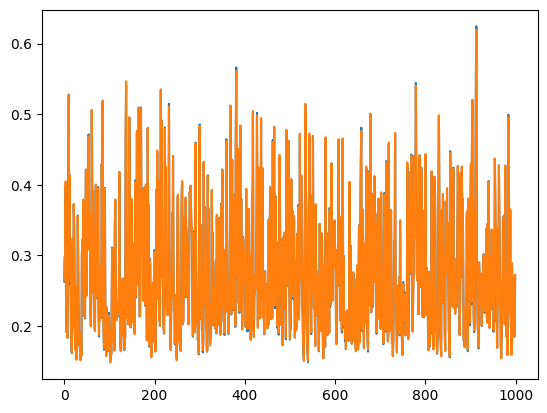

In [53]:

plt.plot(y_val)
plt.plot(y_val_pred1)


In [57]:
mg = pd.read_csv('../datasets/MG17.csv', header=None)

In [60]:
mg=np.array(mg)

In [73]:
mg.shape
mg_input =mg[:, :-10]
mg_target=mg[:, 10:]

In [74]:
mg_input.shape

(1, 9990)

In [75]:
mg_x_train = mg_input[:,:5000].T
mg_x_val = mg_input[:,5000:6000].T
mg_x_test= mg_input[:,6000:].T

mg_y_train = mg_target[:,:5000].T
mg_y_val = mg_target[:,5000:6000].T
mg_y_test= mg_target[:,6000:].T




In [76]:
esn = EchoStateNetwork(1,300, 1.1,1.1,head=LeastMeanSquares())

In [77]:
esn.fit(mg_x_train, mg_y_train)

In [78]:
mg_y_val_pred=esn.predict(mg_x_val)

In [79]:
mean_absolute_error(mg_y_val, mg_y_val_pred)

0.000751280063432801

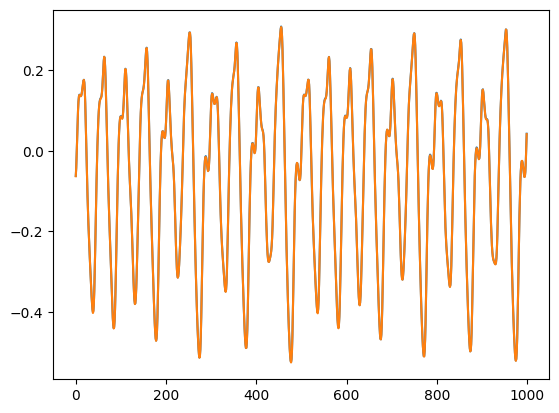

In [80]:
plt.plot(mg_y_val)
plt.plot(mg_y_val_pred)